Enter Circuit Type (e.g., Full_Adder): Ripple_Subtractor
Enter Bit Width (e.g., 1): 4

🤖 Using ML model prediction for gate configuration.

Predicted Gate Counts, Transistor Usage, and Power:
AND Gates: 8 × 6.0 transistors = 48.0
            Static Power: 1.01e-07 W
            Dynamic Power: 1.05e-06 W
            Short-Circuit Power: 1.00e-07 W

OR Gates: 4 × 6.0 transistors = 24.0
            Static Power: 4.93e-08 W
            Dynamic Power: 5.15e-07 W
            Short-Circuit Power: 4.81e-08 W

NOT Gates: 4 × 2 transistors = 8
            Static Power: 6.00e-08 W
            Dynamic Power: 8.40e-06 W
            Short-Circuit Power: 2.80e-06 W

XOR Gates: 8 × 10.0 transistors = 80.0
            Static Power: 1.00e-07 W
            Dynamic Power: 1.03e-06 W
            Short-Circuit Power: 9.69e-08 W

🔩 Total Transistors: 160
💡 Total Static Power: 3.10e-07 W
⚡ Total Dynamic Power: 1.10e-05 W
🔥 Total Short-Circuit Power: 3.04e-06 W
🔋 Total Power Consumption: 1.43e-05 W

📈 Do you w

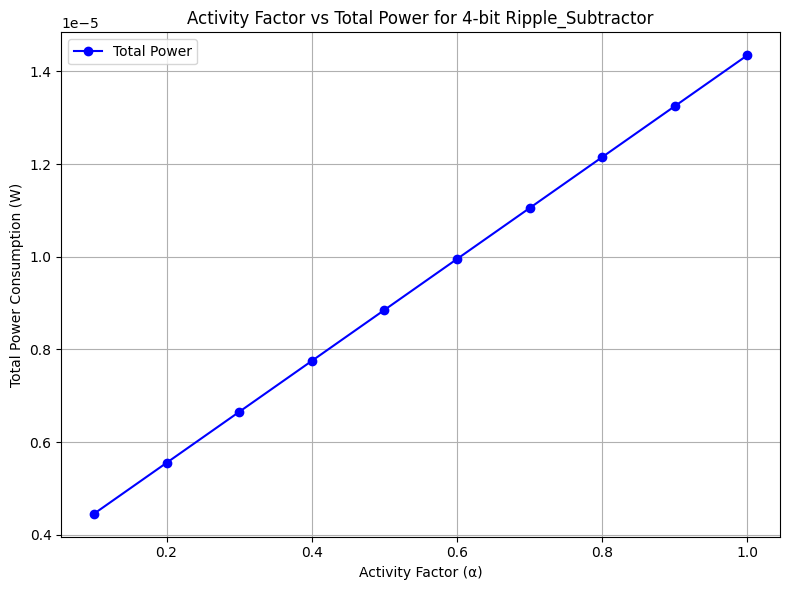

📁 Power data saved to: 4bit_ripple_subtractor_activity_power.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load datasets
gate_samples_df = pd.read_csv("/content/final_5000_gate_samples (1).csv")
transistor_data_df = pd.read_csv("/content/synthetic_cmos_power_dataset (2) (1) (1) (2) (1).csv")

# Step 1: Extract transistor count and power details
avg_data = transistor_data_df.groupby('Circuit_Type').agg({
    'No_Of_Transistors': 'mean',
    'Static_Power': 'mean',
    'Dynamic_Power': 'mean',
    'Short_ckt_Power': 'mean'
}).to_dict()

# Default values
defaults = {
    'AND': {'No_Of_Transistors': 6, 'Static_Power': 2.37e-8, 'Dynamic_Power': 3.85e-6, 'Short_ckt_Power': 1.20e-6},
    'OR':  {'No_Of_Transistors': 6, 'Static_Power': 2.15e-8, 'Dynamic_Power': 3.60e-6, 'Short_ckt_Power': 1.10e-6},
    'XOR': {'No_Of_Transistors': 10, 'Static_Power': 3.80e-8, 'Dynamic_Power': 6.25e-6, 'Short_ckt_Power': 1.50e-6},
    'NOT': {'No_Of_Transistors': 2, 'Static_Power': 1.50e-8, 'Dynamic_Power': 2.10e-6, 'Short_ckt_Power': 0.70e-6}
}

# Combine with actual data
gate_metrics = {}
for gate in ['AND', 'OR', 'XOR', 'NOT']:
    gate_metrics[gate] = {
        'No_Of_Transistors': avg_data['No_Of_Transistors'].get(gate, defaults[gate]['No_Of_Transistors']),
        'Static_Power': avg_data['Static_Power'].get(gate, defaults[gate]['Static_Power']),
        'Dynamic_Power': avg_data['Dynamic_Power'].get(gate, defaults[gate]['Dynamic_Power']),
        'Short_ckt_Power': avg_data['Short_ckt_Power'].get(gate, defaults[gate]['Short_ckt_Power']),
    }

# Step 2–4: Model pipeline
X = gate_samples_df[['Circuit_Type', 'Bit_Width']]
y = gate_samples_df[['AND_Gates', 'OR_Gates', 'NOT_Gates', 'XOR_Gates']]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Circuit_Type'])
], remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Step 5: Manual overrides
manual_gate_library = {
    ('Full_Adder', 1): {'AND': 3, 'OR': 1, 'NOT': 0, 'XOR': 2},
    ('Half_Adder', 1): {'AND': 1, 'OR': 0, 'NOT': 0, 'XOR': 1},
    ('Half_Subtractor', 1): {'AND': 1, 'OR': 0, 'NOT': 1, 'XOR': 1},
    ('Full_Subtractor', 1): {'AND': 2, 'OR': 1, 'NOT': 2, 'XOR': 2}
}

# Step 6: Function to predict and optionally plot
def predict_transistors_and_power():
    circuit_type = input("Enter Circuit Type (e.g., Full_Adder): ")
    bit_width = int(input("Enter Bit Width (e.g., 1): "))

    if (circuit_type, bit_width) in manual_gate_library:
        gate_counts = {k: v * bit_width for k, v in manual_gate_library[(circuit_type, 1)].items()}
        print("\n📌 Using manual logic for accurate known circuit configuration.")
    else:
        sample_input = pd.DataFrame([{'Circuit_Type': circuit_type, 'Bit_Width': bit_width}])
        predicted_gates = model.predict(sample_input).astype(int)[0]
        gate_types = ['AND', 'OR', 'NOT', 'XOR']
        gate_counts = dict(zip(gate_types, predicted_gates))
        print("\n🤖 Using ML model prediction for gate configuration.")

    # Calculate power and transistors
    total_transistors = 0
    total_static_power = 0
    total_dynamic_power = 0
    total_short_power = 0

    print("\nPredicted Gate Counts, Transistor Usage, and Power:")
    for gate in ['AND', 'OR', 'NOT', 'XOR']:
        count = gate_counts.get(gate, 0)
        metrics = gate_metrics[gate]
        transistors = count * metrics['No_Of_Transistors']
        static_power = count * metrics['Static_Power']
        dynamic_power = count * metrics['Dynamic_Power']
        short_power = count * metrics['Short_ckt_Power']

        total_transistors += transistors
        total_static_power += static_power
        total_dynamic_power += dynamic_power
        total_short_power += short_power

        print(f"{gate} Gates: {count} × {metrics['No_Of_Transistors']} transistors = {transistors}")
        print(f"            Static Power: {static_power:.2e} W")
        print(f"            Dynamic Power: {dynamic_power:.2e} W")
        print(f"            Short-Circuit Power: {short_power:.2e} W\n")

    total_power = total_static_power + total_dynamic_power + total_short_power

    print(f"🔩 Total Transistors: {int(total_transistors)}")
    print(f"💡 Total Static Power: {total_static_power:.2e} W")
    print(f"⚡ Total Dynamic Power: {total_dynamic_power:.2e} W")
    print(f"🔥 Total Short-Circuit Power: {total_short_power:.2e} W")
    print(f"🔋 Total Power Consumption: {total_power:.2e} W")

    # Ask to plot graph
    plot_choice = input("\n📈 Do you want to plot Activity Factor vs Total Power? (yes/no): ").strip().lower()
    if plot_choice == 'yes':
        activity_factors = np.linspace(0.1, 1.0, 10)
        results = []

        for alpha in activity_factors:
            dynamic_power = sum(gate_counts[g] * gate_metrics[g]['Dynamic_Power'] * alpha for g in gate_counts)
            static_power = sum(gate_counts[g] * gate_metrics[g]['Static_Power'] for g in gate_counts)
            short_power = sum(gate_counts[g] * gate_metrics[g]['Short_ckt_Power'] for g in gate_counts)
            total = static_power + dynamic_power + short_power

            results.append({
                'Activity_Factor': alpha,
                'Static_Power': static_power,
                'Dynamic_Power': dynamic_power,
                'Short_ckt_Power': short_power,
                'Total_Power': total
            })

        df_results = pd.DataFrame(results)
        plt.figure(figsize=(8, 6))
        plt.plot(df_results['Activity_Factor'], df_results['Total_Power'], marker='o', color='blue', label='Total Power')
        plt.title(f'Activity Factor vs Total Power for {bit_width}-bit {circuit_type}')
        plt.xlabel('Activity Factor (α)')
        plt.ylabel('Total Power Consumption (W)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Save results
        file_name = f"{bit_width}bit_{circuit_type.lower()}_activity_power.csv".replace(" ", "_")
        df_results.to_csv(file_name, index=False)
        print(f"📁 Power data saved to: {file_name}")

# Run the function
predict_transistors_and_power()



